In [1]:
import cv2
import os
import random
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

In [2]:
#Steup paths
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [3]:
#Make the directories
os.makedirs(POS_PATH, exist_ok=True)
os.makedirs(NEG_PATH, exist_ok=True)
os.makedirs(ANC_PATH, exist_ok=True)

In [4]:
#Move LFW images to the following repository data/negative
lfw_path = 'lfw'

for directory in os.listdir(lfw_path):
    directory_path = os.path.join(lfw_path, directory)
    for file in os.listdir(directory_path):
        EX_PATH = os.path.join(directory_path, file) #Defining exisiting path
        NEW_PATH = os.path.join(NEG_PATH, file)
        os.replace(EX_PATH, NEW_PATH)

In [5]:
#Lib to generate unique image names- uuid (Universally unique indentifiers)
import uuid

In [104]:
#Collect Positive and Anchor classes

cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()

    #Cut down frame to 250x250 pixels
    frame = frame[120:120+250, 200:200+250, :]

    #Collect anchors
    if cv2.waitKey(1) & 0xFF == ord('a'):
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        cv2.imwrite(imgname, frame)

    #Collect positives
    if cv2.waitKey(1) & 0xFF == ord('p'):
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        cv2.imwrite(imgname, frame)
    
    cv2.imshow('Image Collection', frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

In [105]:
#Get image directories
anchor = tf.data.Dataset.list_files(ANC_PATH+'\*.JPG').take(300)
positive = tf.data.Dataset.list_files(POS_PATH+'\*.JPG').take(300)
negative = tf.data.Dataset.list_files(NEG_PATH+'\*.JPG').take(300)

In [106]:
dir_test = anchor.as_numpy_iterator()
print(dir_test.next())

b'data\\anchor\\32e19d42-3b0b-11ef-bfa1-505a65ba4b22.jpg'


In [107]:
#Preprocessing - Scale and Resize
def preprocess(file_path):
    byte_img = tf.io.read_file(file_path)
    #After reading the image loading the image
    img = tf.io.decode_jpeg(byte_img)
    
    img = tf.image.resize(img, (100,100))
    img = img / 255.0 #Scale image b/w 0 & 1
    return img

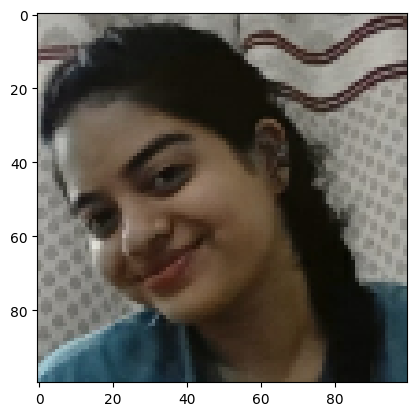

In [109]:
img = preprocess('data\\anchor\\32e19d42-3b0b-11ef-bfa1-505a65ba4b22.jpg')
plt.imshow(img)

In [110]:
#Create Labelled dataset
#(anchor, positive) => 1,1,1,1,1
#(anchor, negative) => 0,0,0,0,0

positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [126]:
samples = data.as_numpy_iterator()
example = samples.next()
example

(b'data\\anchor\\ff08cbf1-3b0a-11ef-9d2f-505a65ba4b22.jpg',
 b'data\\positive\\7a046c95-3b0b-11ef-a7d2-505a65ba4b22.jpg',
 1.0)

In [127]:
#Build Train and Test Partition
def preprocess_twin(input_img, val_img, label):
    return(preprocess(input_img), preprocess(val_img), label)

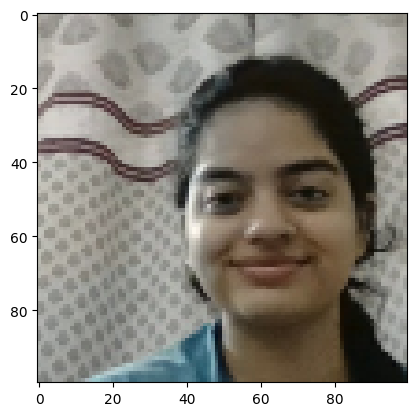

In [128]:
result = preprocess_twin(*example)
plt.imshow(result[1])

In [129]:
result[2]

1.0

In [130]:
#Build dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size = 1024)

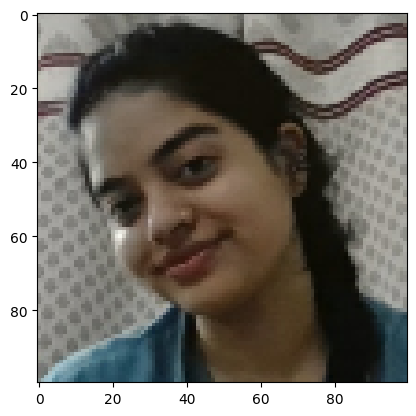

In [131]:
sample = data.as_numpy_iterator()
a = sample.next()
plt.imshow(a[0]) #anchor image

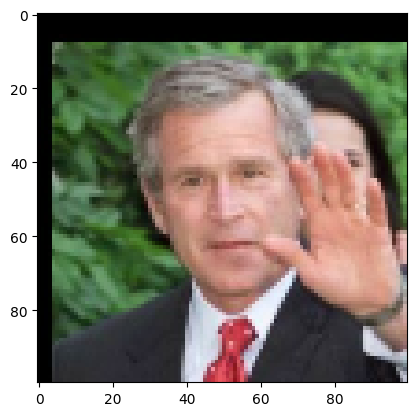

In [132]:
plt.imshow(a[1]) #positve or negative image

In [133]:
a[2] #Label

0.0

In [134]:
#Training partition
train_data = data.take(round(len(data)*.7)) #70% of data for training
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [135]:
train_samples = train_data.as_numpy_iterator()
train_sample = train_samples.next()
len(train_sample[0])

16

In [136]:
#Testing partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

In [137]:
#Build Embedding layer
def make_embedding():
    inp = Input(shape = (100, 100, 3), name = 'input_image')

    # First block
    c1 = Conv2D(64, (10, 10), activation = 'relu')(inp)
    m1 = MaxPooling2D((2, 2), padding = 'same')(c1)

    # Second block
    c2 = Conv2D(128, (7, 7), activation = 'relu')(m1)
    m2 = MaxPooling2D((2, 2), padding = 'same')(c2)

    # Third block
    c3 = Conv2D(128, (4, 4), activation = 'relu')(m2)
    m3 = MaxPooling2D((2, 2), padding = 'same')(c3)

    # Final block
    c4 = Conv2D(256, (4, 4), activation = 'relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation = 'sigmoid')(f1)
    
    return Model(inputs = inp, outputs = d1, name = 'embedding')

In [138]:
embedding_model = make_embedding()
embedding_model.summary()

Model: "embedding"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)             │ (None, 100, 100, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 91, 91, 64)          │          19,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 46, 46, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 40, 40, 128)         │         401,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 17, 17, 128)         │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 9, 9, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 6, 6, 256)           │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 9216)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 4096)                │      37,752,832 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 38,960,448 (148.62 MB)

 Trainable params: 38,960,448 (148.62 MB)

 Non-trainable params: 0 (0.00 B)

In [139]:
#Build Distance layer

#Siamese L1 Distance class
class L1Dist(Layer):
    def __init__(self, **kwargs):
        super(L1Dist, self).__init__(**kwargs)

    # Similarity calculation
    def call(self, input_embedding, val_embedding):
        return tf.math.abs(input_embedding - val_embedding)

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[1])

In [140]:
#Make Siamese model
def make_siamese_model():
    # Anchor image input in the network
    input_img = Input(shape=(100, 100, 3), name='input_img')

    # Validation image input in the network
    val_img = Input(shape=(100, 100, 3), name='val_img')

    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    
    # New layer
    distances = siamese_layer(embedding_model(input_img), embedding_model(val_img))

    # Classification layer
    classifier = Dense(1, activation='sigmoid')(distances)

    return Model(inputs=[input_img, val_img], outputs=classifier, name='SiameseNetwork')

In [141]:
siamese_model = make_siamese_model()
siamese_model.summary()

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_img (InputLayer)        │ (None, 100, 100, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ val_img (InputLayer)          │ (None, 100, 100, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding (Functional)        │ (None, 4096)              │      38,960,448 │ input_img[0][0],           │
│                               │                           │                 │ val_img[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ l1_dist_1 (L1Dist)            │ (None, 4096)              │               0 │ embedding[0][0],           │
│                               │                           │                 │ embedding[1][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_3 (Dense)               │ (None, 1)                 │           4,097 │ l1_dist_1[0][0]            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

In [142]:
#Setuo Loss Function and Optimizer
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [143]:
#using Adam's Optimization algorithm
opt = tf.keras.optimizers.Adam(1e-4) #learnign rate = 0.0001

In [144]:
#Establish checkpoints
checkpnt_dir = './training_checkpoints'
checkpnt_prefix = os.path.join(checkpnt_dir, 'ckpt')
checkpnt = tf.train.Checkpoint(opt = opt, siamese_model = siamese_model)

In [145]:
#Build train step function
@tf.function
def train_step(batch):
    with tf.GradientTape() as tape:
        #Get anchor & positive/negative image
        X = batch[:2]  
        anchor_img = X[0]
        val_img = X[1]
        #Get label
        y = batch[2]

        #Forward pass
        yhat = siamese_model([anchor_img, val_img], training = True)
        #Calculate Loss
        loss = binary_cross_loss(y, yhat)
    
    #calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)

    #Calculate updated weights and apply to a siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))

    return loss

In [146]:
#Build training loop
def train(data, EPOCHS):
    #loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data)) #Progess bar

        #loop thorugh ech batch
        for idx, batch in enumerate(data):
            loss = train_step(batch)
            progbar.update(idx+1, [('loss', loss)])

        #Save checkpoints
        if epoch % 10 == 0:
            checkpnt.save(file_prefix = checkpnt_prefix)

In [147]:
#Train the model
EPOCHS = 50

In [148]:
train(train_data, EPOCHS)


 Epoch 1/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 112s 4s/step - loss: 0.4764

 Epoch 2/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 117s 4s/step - loss: 0.2150

 Epoch 3/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 114s 4s/step - loss: 0.1118

 Epoch 4/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 117s 4s/step - loss: 0.1414

 Epoch 5/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 102s 4s/step - loss: 0.0640

 Epoch 6/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 117s 4s/step - loss: 0.0415

 Epoch 7/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 112s 4s/step - loss: 0.0441

 Epoch 8/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 119s 4s/step - loss: 0.0272

 Epoch 9/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 114s 4s/step - loss: 0.0165

 Epoch 10/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 109s 4s/step - loss: 0.0093

 Epoch 11/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 116s 4s/step - loss: 0.0040

 Epoch 12/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 119s 4s/step - loss: 0.0243

 Epoch 13/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 120s 4s/step - loss: 0.0106

 Epoch 14/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 118s 4s/step - loss: 0.0040

 Epoch 15/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 11

In [149]:
#Evaluate model
from tensorflow.keras.metrics import Precision, Recall

In [201]:
#Get a batch of test data
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [202]:
#Make predictions
y_hat = siamese_model.predict([test_input, test_val])
y_hat

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step


array([[1.1218060e-09],
       [1.0321391e-11],
       [9.9999166e-01],
       [1.3834777e-11],
       [6.8881297e-07],
       [9.9973124e-01],
       [1.4801401e-09],
       [9.9999946e-01],
       [2.9157009e-06],
       [9.9999958e-01],
       [1.0000000e+00],
       [4.8889444e-09],
       [1.0000000e+00],
       [1.0000000e+00],
       [2.6164361e-11],
       [3.0566405e-09]], dtype=float32)

In [203]:
#Post processing the results
[1 if prediction > 0.5 else 0 for prediction in y_hat] #binary values

[0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0]

In [204]:
y_true

array([0., 0., 1., 0., 0., 1., 0., 1., 0., 1., 1., 0., 1., 1., 0., 0.],
      dtype=float32)

In [205]:
#Creating a metric object
m = Recall()

#Updating the recall value
m.update_state(y_true, y_hat)

m.result().numpy()

1.0

In [206]:
#Creating a metric object
m = Precision()

#Updating the precision value
m.update_state(y_true, y_hat)

m.result().numpy()

1.0

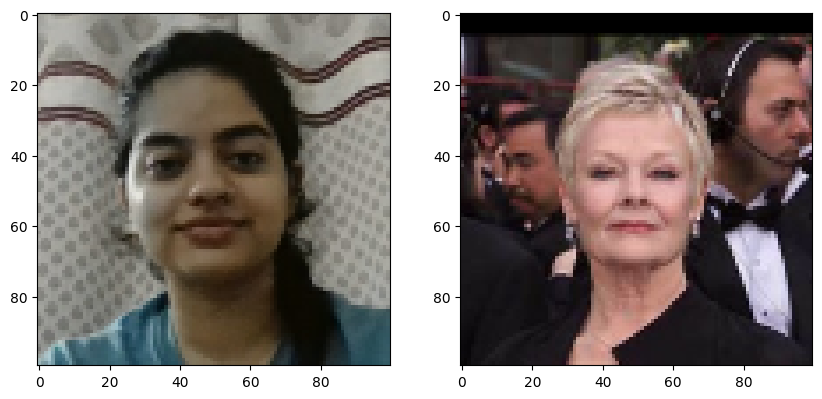

In [208]:
#Visualization
plt.figure(figsize = (10,8))
plt.subplot(1,2,1)
plt.imshow(test_input[1])
plt.subplot(1,2,2)
plt.imshow(test_val[1])
plt.show()

In [209]:
#Save model weights
siamese_model.save('siamesemodel.keras')

In [210]:
#Reload model
model = tf.keras.models.load_model('siamesemodel.keras', \
                                   custom_objects = {'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [211]:
model.predict([test_input, test_val])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 524ms/step


array([[1.1218060e-09],
       [1.0321391e-11],
       [9.9999166e-01],
       [1.3834777e-11],
       [6.8881297e-07],
       [9.9973124e-01],
       [1.4801401e-09],
       [9.9999946e-01],
       [2.9157009e-06],
       [9.9999958e-01],
       [1.0000000e+00],
       [4.8889444e-09],
       [1.0000000e+00],
       [1.0000000e+00],
       [2.6164361e-11],
       [3.0566405e-09]], dtype=float32)

In [212]:
#Make rpedictions with reloaded model
model.summary()

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_img (InputLayer)        │ (None, 100, 100, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ val_img (InputLayer)          │ (None, 100, 100, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding (Functional)        │ (None, 4096)              │      38,960,448 │ input_img[0][0],           │
│                               │                           │                 │ val_img[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ l1_dist_1 (L1Dist)            │ (None, 4096)              │               0 │ embedding[0][0],           │
│                               │                           │                 │ embedding[1][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_3 (Dense)               │ (None, 1)                 │           4,097 │ l1_dist_1[0][0]            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

In [213]:
#Verification Function
def verify(model, detection_threshold, verification_threshold):
    #Build result array
    results = []
    verification_image_path = os.path.join('application_data', 'verification_image')

    for image in os.listdir(verification_image_path):
        input_img = preprocess(os.path.join('application_data', 'input_image', 'input_image.jpg'))
        val_img = preprocess(os.path.join(verification_image_path, image))

        #Make predictions
        result = model.predict([np.expand_dims(input_img, axis=0), np.expand_dims(val_img, axis=0)])
        results.append(result)

    #Detection threshold : Metric above which a prediction is considered positive
    detection = np.sum(np.array(results) > detection_threshold)

     #Verification threshold : Propotion of positive predcition predictions/total positive samples
    verification = detection / len(os.listdir(verification_image_path))
    verified = verification > verification_threshold

    print(f"Detection count: {detection}")
    print(f"Verification ratio: {verification}")
    print(f"Verified: {verified}")

    return results, verified

In [214]:
#Real time detection
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[120:120+250, 200:200+250, :]

    cv2.imshow('Verification', frame)
    
    #Verification trigger
    key = cv2.waitKey(10) & 0xFF
    if key == ord('v'):
        # Save input image to application_data/input_image folder
        input_img = os.path.join('application_data', 'input_image', 'input_image.jpg')
        cv2.imwrite(input_img, frame)
        # Verification function
        results, verified = verify(model, 0.9, 0.5)
        print(f"Verification result: {verified}")

    if key == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━